In [40]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
import h5py
import os
print(os.listdir("../input"))

['FlowerColorImages.h5', 'flower_images']


> **Prepare Training Data using h5 File**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Keys: <KeysViewHDF5 ['images', 'labels']>


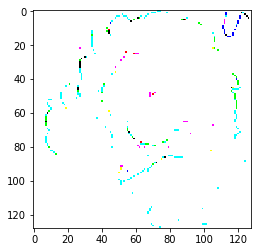

In [41]:
filename = '../input/FlowerColorImages.h5'
f = h5py.File(filename, 'r')

# List all groups
print("Keys: %s" % f.keys())
a_group_key = list(f.keys())[0]


# Get the training data
h5_images = list(f['images'])
h5_labels = list(f['labels'])

plt.imshow(h5_images[0])  # graph it
plt.show()

In [42]:
h5_training_data = []
train_y = pd.Series(h5_labels)
IMG_SIZE = 50


def h5_create_training_data():
    for img in h5_images:
        try:
            new_img_array = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
            h5_training_data.append(new_img_array)
        except Exception as e:  # in the interest in keeping the output clean...
            print(e)

        
h5_create_training_data()
print(len(h5_training_data))

210


In [43]:
h5_train_X = np.array(h5_training_data).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
h5_train_X.shape

(210, 50, 50, 3)

> **Prepare Training Data**

In [44]:
flowers = pd.read_csv("../input/flower_images/flower_images/flower_labels.csv")

flowers.head()

,file,label
0,0001.png,0
1,0002.png,0
2,0003.png,2
3,0004.png,0
4,0005.png,0


In [45]:
imgs = flowers['file']
training_data = []
y = flowers['label'].values

def create_training_data():
    img_path = "../input/flower_images/flower_images/" 
    
    for im in imgs:
        try:
            img_array = cv2.imread(os.path.join(img_path,im))  # convert to array
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
            training_data.append(new_array)
        except Exception as e:  # in the interest in keeping the output clean...
            print(e)

create_training_data()
print(len(training_data))

210


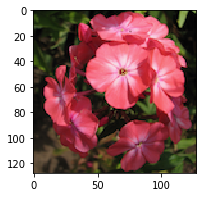

In [46]:
flower_image = cv2.imread("../input/flower_images/flower_images/" + imgs[0])
rgb_flower_image = cv2.cvtColor(flower_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(3,3))
plt.imshow(rgb_flower_image);

In [47]:
Data = np.array(training_data).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Data.shape

(210, 50, 50, 3)

In [48]:
x_train, x_test, y_train, y_test = train_test_split(Data, y, 
                                                    test_size = 0.2, random_state = 1)
[x_train.shape, y_train.shape, x_test.shape, y_test.shape]

[(168, 50, 50, 3), (168,), (42, 50, 50, 3), (42,)]

In [49]:
n = int(len(x_test)/2)
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]
x_train.shape, x_test.shape, x_valid.shape, y_train.shape, y_test.shape, y_valid.shape

((168, 50, 50, 3), (21, 50, 50, 3), (21, 50, 50, 3), (168,), (21,), (21,))

In [50]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_valid = x_valid.astype('float32')/255

c_y_train = to_categorical(y_train, 10)
c_y_test = to_categorical(y_test, 10)
c_y_valid = to_categorical(y_valid, 10)

[x_train.shape, c_y_train.shape, x_test.shape, c_y_test.shape, x_valid.shape, c_y_valid.shape]

[(168, 50, 50, 3),
 (168, 10),
 (21, 50, 50, 3),
 (21, 10),
 (21, 50, 50, 3),
 (21, 10)]

> **Training and Prediction**

In [57]:
# CNN
def cnn_mc_model():
    model = Sequential()

    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(96, (5, 5)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

#     model.add(Flatten())
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(512, activation='tanh'))
    model.add(Dropout(0.25)) 
    
#    model.add(Dense(256, activation='tanh'))
#    model.add(Dropout(0.25)) 
    
    model.add(Dense(128, activation='tanh'))
    model.add(Dropout(0.25)) 

    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    return model

cnn_mc_model = cnn_mc_model()

In [62]:
cnn_mc_history = cnn_mc_model.fit(x_train, c_y_train, 
                                  epochs=50, batch_size=64, verbose=2,
                                  validation_data=(x_valid, c_y_valid))

Train on 168 samples, validate on 21 samples
Epoch 1/50
 - 1s - loss: 0.7491 - acc: 0.7143 - val_loss: 1.0311 - val_acc: 0.6190
Epoch 2/50
 - 1s - loss: 0.7886 - acc: 0.7262 - val_loss: 0.9119 - val_acc: 0.6667
Epoch 3/50
 - 1s - loss: 0.7425 - acc: 0.7381 - val_loss: 1.0851 - val_acc: 0.6190
Epoch 4/50
 - 1s - loss: 0.7094 - acc: 0.7440 - val_loss: 1.0573 - val_acc: 0.6667
Epoch 5/50
 - 1s - loss: 0.7814 - acc: 0.6905 - val_loss: 1.1797 - val_acc: 0.5714
Epoch 6/50
 - 1s - loss: 0.6746 - acc: 0.7619 - val_loss: 1.0580 - val_acc: 0.6667
Epoch 7/50
 - 1s - loss: 0.6101 - acc: 0.7798 - val_loss: 0.9638 - val_acc: 0.6667
Epoch 8/50
 - 1s - loss: 1.0178 - acc: 0.6548 - val_loss: 1.6723 - val_acc: 0.5714
Epoch 9/50
 - 1s - loss: 1.2085 - acc: 0.5833 - val_loss: 1.5480 - val_acc: 0.5238
Epoch 10/50
 - 1s - loss: 0.9166 - acc: 0.6905 - val_loss: 1.1159 - val_acc: 0.6667
Epoch 11/50
 - 1s - loss: 0.7031 - acc: 0.7440 - val_loss: 1.1142 - val_acc: 0.6190
Epoch 12/50
 - 1s - loss: 0.5685 - acc: 

In [63]:
cnn_mc_test_score = cnn_mc_model.evaluate(x_test, c_y_test)
cnn_mc_test_score

21/21 [==============================] - 0s 2ms/sample - loss: 0.8382 - acc: 0.6190


[0.8382043242454529, 0.61904764]